In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import time
import sys
import os
import datetime

import poloniex

from keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.python.client import device_lib

sys.path.append('../')

import lstm

print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14019243039594471971
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7059695207
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16076679045016963327
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
dir_model = '../../Model/lstm-1/'
os.makedirs(dir_model, exist_ok=True)

In [3]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding_len = i * prediction_len
        padding = [None for p in range(padding_len)]
        plt.plot(padding + data, label='Prediction')
        plt.scatter(np.argmin(data)+padding_len, np.amin(data), c='red', marker='o')
        plt.scatter(np.argmax(data)+padding_len, np.amax(data), c='blue', marker='o')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [4]:
coin = 'BTC'
data_len = 365 * 5

In [5]:
polo = poloniex.Poloniex()
period = polo.DAY # period of data
end = time.time()
start = end - period * (data_len + 50) # +50 to calcurate SMA50

chart = polo.returnChartData('USDT_%s'%coin, period=period, start=start, end=end)

In [6]:
df = DataFrame.from_dict(chart)
timestamp = df['date'].values.tolist() # Series -> ndarray -> list
# timestamp -> year/month/day
date = [datetime.datetime.fromtimestamp(timestamp[i]).date() for i in range(len(timestamp))]
df = df.astype(float)
df['date'] = date
df['timestamp'] = timestamp

In [7]:
df.drop(['quoteVolume', 'weightedAverage'], axis=1, inplace=True)
df['EMA20'] = df['close'].ewm(span=20).mean()
df['SMA50'] = df['close'].rolling(window=50).mean()
df['return'] = df['close'].pct_change()

r = df['close'].rolling(20)
df['upper'] = r.mean() + 2 * r.std()
df['lower'] = r.mean() - 2 * r.std()

df.tail()

,date,high,low,open,close,volume,timestamp,EMA20,SMA50,return,upper,lower
1871,2021-05-16,49779.978298,43867.298194,46778.196625,46395.317265,8.304694e+07,1621123200,53198.106662,56210.417398,-0.008396,62225.594261,46645.821788
1872,2021-05-17,46600.000000,42142.857143,46418.765995,43533.076068,9.767998e+07,1621209600,52277.627558,55965.599677,-0.061692,63040.402829,44682.930925
1873,2021-05-18,45761.788124,42280.434730,43552.805558,42861.821506,6.311084e+07,1621296000,51380.884125,55670.419918,-0.015419,63656.625633,42870.190272
1874,2021-05-19,43548.000000,30010.000000,42833.318454,36645.542396,2.542155e+08,1621382400,49977.518246,55228.370766,-0.145031,65190.405327,39645.871640
1875,2021-05-20,40432.017105,34911.953369,36672.945300,40053.913577,4.307398e+07,1621468800,49032.413039,54854.582287,0.093009,65186.426705,37889.668047


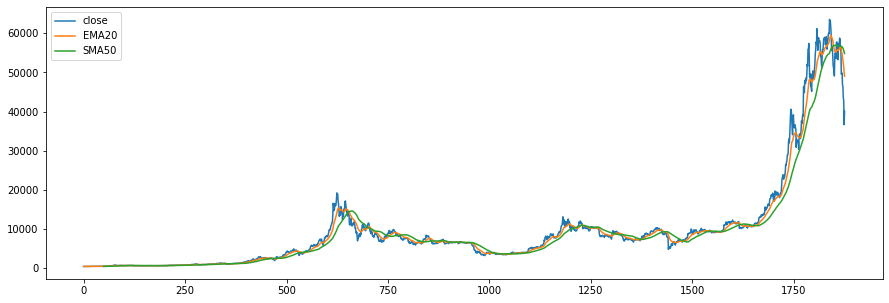

In [8]:
df[['close', 'EMA20', 'SMA50']].plot(subplots=False, figsize=(15, 5))

In [9]:
# Types of data used for estimate
data_type = ['close', 'EMA20', 'SMA50', 'volume', 'upper', 'lower']

In [10]:
data = df[data_type].values
data = np.nan_to_num(data)
data = data[-data_len:]
print('data shape: ', data.shape)

data shape:  (1825, 6)


In [11]:
# Normalization
norm_data = np.zeros_like(data)
for i in range(data.shape[1]):
    col = data[:, i]
    mean = np.mean(col)
    std = np.std(col)
    norm = (col - mean) / std
    norm_data[:, i] = norm

In [12]:
seq_len = 28 * 2
estimate_len = 7

test_len = estimate_len * 4
y_len=1

X_train, y_train, X_test, y_test = lstm.gen_data(
    data, 
    seq_len, 
    test_len,
    y_len=y_len, 
    normalise_window=True
)

Window Data Shape:  (1769, 57, 6)


In [13]:
print('Train length = ', X_train.shape[0])
print('Test length = ', X_test.shape[0])

Train length =  1741
Test length =  28


In [14]:
input_ch = len(data_type)
hidden_layer = 400

model = lstm.build_model([input_ch, seq_len, hidden_layer, y_len])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model_save_cb = ModelCheckpoint(dir_model + 'model-lstm_best.hdf5',
                                period=1,
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                save_weights_only=True)
csv_logger_cb = CSVLogger(dir_model + 'model-lstm.log', append=False)

In [16]:
epoch = 1000

start = time.time()

model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=epoch, 
          shuffle=True,
          validation_split=0.2, 
          callbacks=[model_save_cb, csv_logger_cb],
          verbose=0)
model.save_weights(dir_model + 'model-lstm_final.hdf5')

print('学習時間：', time.time() - start)

Instructions for updating:
Use tf.cast instead.
学習時間： 1144.8557279109955


(0, 0.013554061310235035)

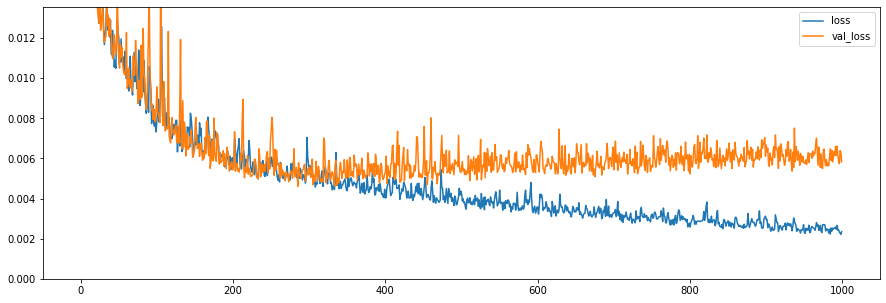

In [20]:
df_log = pd.read_csv(dir_model + 'model-lstm.log')
df_log[['loss', 'val_loss']].plot(subplots=False, figsize=(15, 5))
plt.ylim(0, np.mean(df_log['val_loss'])*2)

In [18]:
pred_len = 7
model.load_weights(dir_model + 'model-lstm_best.hdf5')
predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, pred_len)

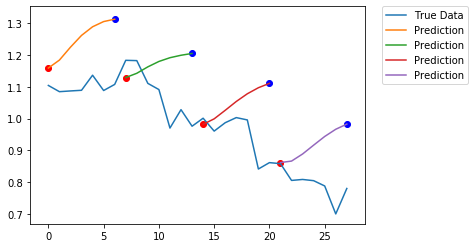

In [19]:
plot_results_multiple(predictions, y_test, pred_len)

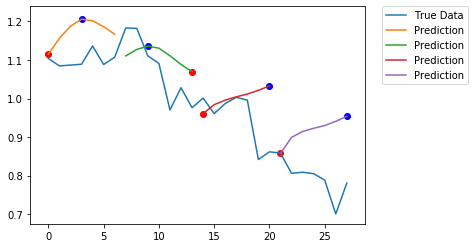

In [21]:
model.load_weights(dir_model + 'model-lstm_final.hdf5')
predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, pred_len)
plot_results_multiple(predictions, y_test, pred_len)

Mean:51988.8399672568, Std:5876.420147909906


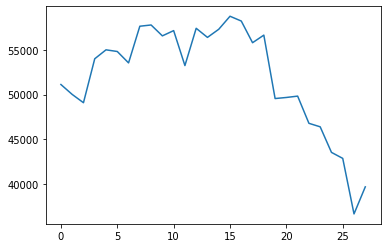

In [20]:
test_data = data[-test_len:, 0]
mean_test = np.mean(test_data)
std_test = np.std(test_data)
print('Mean:{}, Std:{}'.format(mean_test, std_test))
plt.plot(test_data)